In [1]:
!nvidia-smi

Mon Jul  5 05:56:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [28]:
!pip install yfinance
!pip install matplotlib

     |████████████████████████████████| 686kB 5.1MB/s 


In [ ]:
#import library
import os
import numpy as np
import random
import secrets
import pandas as pd
import tensorflow as tf
import yfinance as yf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dropout, Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from datetime import date
from datetime import datetime
from datetime import timedelta
from absl import app

In [77]:
#collect data
class StockData:
    def __init__(self, stock):
        self._stock = stock
        self._sec = yf.Ticker(self._stock.get_ticker())
        self._min_max = MinMaxScaler(feature_range=(0, 1))

    def __data_verification(self, train):
        print('mean:', train.mean(axis=0))
        print('max', train.max())
        print('min', train.min())
        print('Std dev:', train.std(axis=0))

    def get_stock_short_name(self):
        return self._sec.info['shortName']

    def get_min_max(self):
        return self._min_max

    def get_stock_currency(self):
        return self._sec.info['currency']

    def download_transform_to_numpy(self, time_steps, project_folder):
        end_date = datetime.today()
        print('End Date: ' + end_date.strftime("%Y-%m-%d"))
        data = yf.download([self._stock.get_ticker()], start=self._stock.get_start_date(), end=end_date)[['Close']]
        data = data.reset_index()
        data.to_csv(os.path.join(project_folder, 'downloaded_data_'+self._stock.get_ticker()+'.csv'))

        training_data = data[data['Date'] < self._stock.get_validation_date()].copy()
        test_data = data[data['Date'] >= self._stock.get_validation_date()].copy()
        training_data = training_data.set_index('Date')
        test_data = test_data.set_index('Date')

        train_scaled = self._min_max.fit_transform(training_data)
        self.__data_verification(train_scaled)

        x_train = []
        y_train = []
        for i in range(time_steps, train_scaled.shape[0]):
            x_train.append(train_scaled[i - time_steps:i])
            y_train.append(train_scaled[i, 0])

        x_train, y_train = np.array(x_train), np.array(y_train)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

        total_data = pd.concat((training_data, test_data), axis=0)
        inputs = total_data[len(total_data) - len(test_data) - time_steps:]
        test_scaled = self._min_max.fit_transform(inputs)

        x_test = []
        y_test = []
        for i in range(time_steps, test_scaled.shape[0]):
            x_test.append(test_scaled[i - time_steps:i])
            y_test.append(test_scaled[i, 0])

        x_test, y_test = np.array(x_test), np.array(y_test)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        return (x_train, y_train), (x_test, y_test), (training_data, test_data)

    def __date_range(self, start_date, end_date):
        for n in range(int((end_date - start_date).days)):
            yield start_date + timedelta(n)

    def negative_positive_random(self):
        return 1 if random.random() < 0.5 else -1

    def pseudo_random(self):
        return random.uniform(0.01, 0.03)

    def generate_future_data(self, time_steps, min_max, start_date, end_date, latest_close_price):
        x_future = []
        y_future = []

        original_price = latest_close_price

        for single_date in self.__date_range(start_date, end_date):
            x_future.append(single_date)
            direction = self.negative_positive_random()
            random_slope = direction * (self.pseudo_random())
            original_price = original_price + (original_price * random_slope)
            if original_price < 0:
                original_price = 0
            y_future.append(original_price)

        test_data = pd.DataFrame({'Date': x_future, 'Close': y_future})
        test_data = test_data.set_index('Date')

        test_scaled = min_max.fit_transform(test_data)
        x_test = []
        y_test = []
        for i in range(time_steps, test_scaled.shape[0]):
            x_test.append(test_scaled[i - time_steps:i])
            y_test.append(test_scaled[i, 0])

        x_test, y_test = np.array(x_test), np.array(y_test)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        return x_test, y_test, test_data


In [58]:
#create model
class LongShortTermMemory:
    def __init__(self, project_folder):
        self.project_folder = project_folder

    def get_defined_metrics(self):
        defined_metrics = [
            tf.keras.metrics.MeanSquaredError(name='MSE')
        ]
        return defined_metrics

    def get_callback(self):
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
        return callback

    def create_model(self, x_train):
        model = Sequential()
        model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(units=75, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=75, return_sequences=True))
        model.add(Dropout(0.5))
        model.add(LSTM(units=75))
        model.add(Dropout(0.5))
        model.add(Dense(units=1))
        model.summary()
        tf.keras.utils.plot_model(model, to_file=os.path.join(self.project_folder, 'model_lstm.png'), show_shapes=True,
                                  show_layer_names=True)
        return model

In [59]:
#plot
class Plotter:
    def __init__(self, blocking, project_folder, short_name, currency, stock_ticker):
        self.blocking = blocking
        self.project_folder = project_folder
        self.short_name = short_name
        self.currency = currency
        self.stock_ticker = stock_ticker

    def plot_histogram_data_split(self, training_data, test_data, validation_date):
        print("plotting Data and Histogram")
        plt.figure(figsize=(12, 5))
        plt.plot(training_data.Close, color='green')
        plt.plot(test_data.Close, color='red')
        plt.ylabel('Price [' + self.currency + ']')
        plt.xlabel("Date")
        plt.legend(["Training Data", "Validation Data >= " + validation_date.strftime("%Y-%m-%d")])
        plt.title(self.short_name)
        plt.savefig(os.path.join(self.project_folder, self.short_name.strip().replace('.', '') + '_price.png'))

        fig, ax = plt.subplots()
        training_data.hist(ax=ax)
        fig.savefig(os.path.join(self.project_folder, self.short_name.strip().replace('.', '') + '_hist.png'))

        plt.pause(0.001)
        plt.show(block=self.blocking)

    def plot_loss(self, history):
        print("plotting loss")
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss/Validation Loss')
        plt.legend(loc='upper right')
        plt.savefig(os.path.join(self.project_folder, 'loss.png'))
        plt.pause(0.001)
        plt.show(block=self.blocking)

    def plot_mse(self, history):
        print("plotting MSE")
        plt.plot(history.history['MSE'], label='MSE')
        plt.plot(history.history['val_MSE'], label='val_MSE')
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.title('MSE/Validation MSE')
        plt.legend(loc='upper right')
        plt.savefig(os.path.join(self.project_folder, 'MSE.png'))
        plt.pause(0.001)
        plt.show(block=self.blocking)

    def project_plot_predictions(self, price_predicted, test_data):
        print("plotting predictions")
        plt.figure(figsize=(14, 5))
        plt.plot(price_predicted[self.stock_ticker + '_predicted'], color='red', label='Predicted [' + self.short_name + '] price')
        plt.plot(test_data.Close, color='green', label='Actual [' + self.short_name + '] price')
        plt.xlabel('Time')
        plt.ylabel('Price [' + self.currency + ']')
        plt.legend()
        plt.title('Prediction')
        plt.savefig(os.path.join(self.project_folder, self.short_name.strip().replace('.', '') + '_prediction.png'))
        plt.pause(0.001)
        plt.show(block=self.blocking)

In [60]:
def train_LSTM_network(stock):
    data = StockData(stock)
    plotter = Plotter(True, stock.get_project_folder(), data.get_stock_short_name(), data.get_stock_currency(), stock.get_ticker())
    (x_train, y_train), (x_test, y_test), (training_data, test_data) = data.download_transform_to_numpy(TIME_STEPS, stock.get_project_folder())
    plotter.plot_histogram_data_split(training_data, test_data, stock.get_validation_date())

    lstm = LongShortTermMemory(stock.get_project_folder())
    model = lstm.create_model(x_train)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=lstm.get_defined_metrics())
    history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, y_test),
                        callbacks=[lstm.get_callback()])
    print("saving weights")
    model.save(os.path.join(stock.get_project_folder(), 'model_weights.h5'))

    plotter.plot_loss(history)
    plotter.plot_mse(history)

    print("display the content of the model")
    baseline_results = model.evaluate(x_test, y_test, verbose=2)
    for name, value in zip(model.metrics_names, baseline_results):
        print(name, ': ', value)
    print()

    print("plotting prediction results")
    test_predictions_baseline = model.predict(x_test)
    test_predictions_baseline = data.get_min_max().inverse_transform(test_predictions_baseline)
    test_predictions_baseline = pd.DataFrame(test_predictions_baseline)
    test_predictions_baseline.to_csv(os.path.join(stock.get_project_folder(), 'predictions.csv'))

    test_predictions_baseline.rename(columns={0: STOCK_TICKER + '_predicted'}, inplace=True)
    test_predictions_baseline = test_predictions_baseline.round(decimals=0)
    test_predictions_baseline.index = test_data.index
    plotter.project_plot_predictions(test_predictions_baseline, test_data)

    print("prediction is finished")

In [61]:
class StockPrediction:
    def __init__(self, ticker, start_date, validation_date, project_folder):
        self._ticker = ticker
        self._start_date = start_date
        self._validation_date = validation_date
        self._project_folder = project_folder

    def get_ticker(self):
        return self._ticker

    def set_ticker(self, value):
        self._ticker = value

    def get_start_date(self):
        return self._start_date

    def set_start_date(self, value):
        self._start_date = value

    def get_validation_date(self):
        return self._validation_date

    def set_validation_date(self, value):
        self._validation_date = value

    def get_project_folder(self):
        return self._project_folder

    def set_project_folder(self, value):
        self._project_folder = value

Ticker: 2609.TW
Start Date: 2000-07-05
Validation Date: 2019-07-05
Test Run Folder: 2609.TW_20210705_9e0489e48d8cbc46998bbb777a89a7c3
End Date: 2021-07-05
[*********************100%***********************]  1 of 1 completed
mean: [0.31308062]
max 1.0
min 0.0
Std dev: [0.20527068]
plotting Data and Histogram


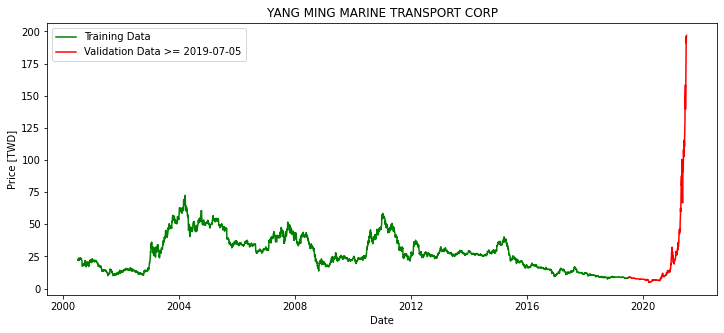

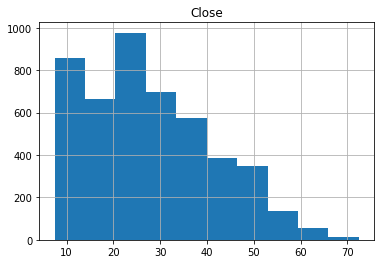

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_66 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
dropout_65 (Dropout)         (None, 3, 100)            0         
_________________________________________________________________
lstm_67 (LSTM)               (None, 3, 75)             52800     
_________________________________________________________________
dropout_66 (Dropout)         (None, 3, 75)             0         
_________________________________________________________________
lstm_68 (LSTM)               (None, 3, 75)             45300     
_________________________________________________________________
dropout_67 (Dropout)         (None, 3, 75)             0         
_________________________________________________________________
lstm_69 (LSTM)               (None, 75)              

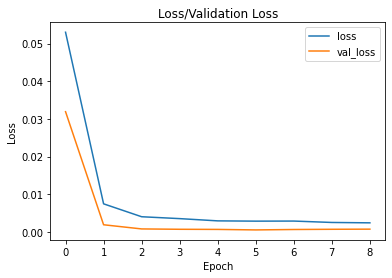

plotting MSE


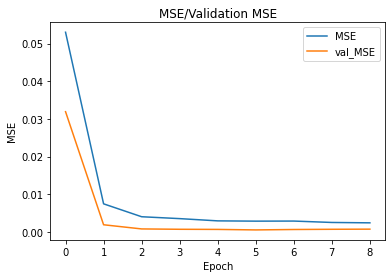

display the content of the model
16/16 - 0s - loss: 7.3852e-04 - MSE: 7.3852e-04
loss :  0.0007385201170109212
MSE :  0.0007385201170109212

plotting prediction results
plotting predictions


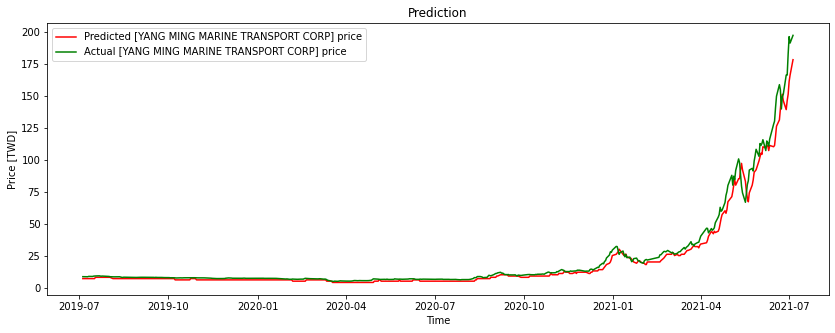

prediction is finished


In [63]:
if __name__ == '__main__':
    STOCK_TICKER = '2609.TW'
    STOCK_START_DATE = pd.to_datetime('2000-07-05')
    STOCK_VALIDATION_DATE = pd.to_datetime('2019-07-05')
    EPOCHS = 100
    BATCH_SIZE = 128
    TIME_STEPS = 3
    TODAY_RUN = datetime.today().strftime("%Y%m%d")
    TOKEN = STOCK_TICKER + '_' + TODAY_RUN + '_' + secrets.token_hex(16)
    print('Ticker: ' + STOCK_TICKER)
    print('Start Date: ' + STOCK_START_DATE.strftime("%Y-%m-%d"))
    print('Validation Date: ' + STOCK_VALIDATION_DATE.strftime("%Y-%m-%d"))
    print('Test Run Folder: ' + TOKEN)
    PROJECT_FOLDER = os.path.join(os.getcwd(), TOKEN)
    if not os.path.exists(PROJECT_FOLDER):
        os.makedirs(PROJECT_FOLDER)

    stock_prediction = StockPrediction(STOCK_TICKER, STOCK_START_DATE, STOCK_VALIDATION_DATE, PROJECT_FOLDER)
    train_LSTM_network(stock_prediction)

2.5.0
End Date: 2021-07-05
[*********************100%***********************]  1 of 1 completed
mean: [0.31308062]
max 1.0
min 0.0
Std dev: [0.20527068]
Latest Stock Price
197.0
Latest Date
2021-07-05 00:00:00
Future Date
2021-07-06 00:00:00
Future Timespan Date
2022-05-01 00:00:00


W0705 09:07:13.822215 140435772872576 recurrent_v2.py:1140] Layer lstm_50 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


W0705 09:07:13.927608 140435772872576 recurrent_v2.py:1140] Layer lstm_51 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


W0705 09:07:14.029353 140435772872576 recurrent_v2.py:1140] Layer lstm_52 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


W0705 09:07:14.130356 140435772872576 recurrent_v2.py:1140] Layer lstm_53 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 3, 150)            91200     
_________________________________________________________________
dropout_49 (Dropout)         (None, 3, 150)            0         
_________________________________________________________________
lstm_51 (LSTM)               (None, 3, 75)             67800     
_________________________________________________________________
dropout_50 (Dropout)         (None, 3, 75)             0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 3, 75)             45300     
_________________________________________________________________
dropout_51 (Dropout)         (None, 3, 75)             0         
_________________________________________________________________
lstm_53 (LSTM)               (None, 75)              

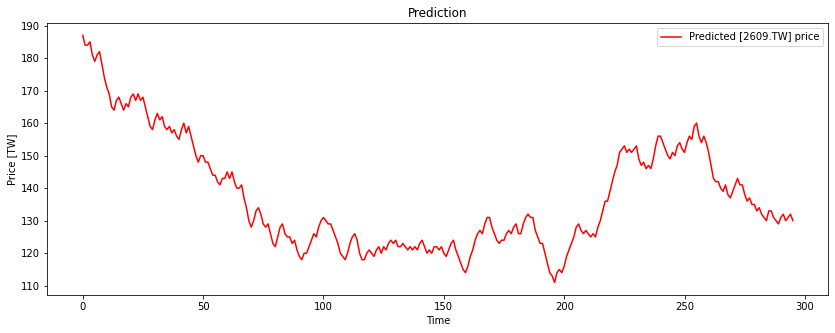

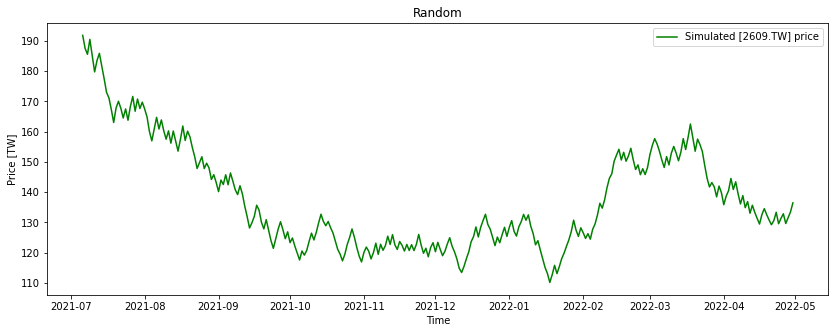

In [85]:
def main():
    print(tf.version.VERSION)
    inference_folder = os.path.join(os.getcwd(), RUN_FOLDER)
    stock = StockPrediction(STOCK_TICKER, STOCK_START_DATE, STOCK_VALIDATION_DATE, inference_folder)

    data = StockData(stock)

    (x_train, y_train), (x_test, y_test), (training_data, test_data) = data.download_transform_to_numpy(TIME_STEPS, inference_folder)
    min_max = data.get_min_max()

    # load future data

    print('Latest Stock Price')
    latest_close_price = test_data.Close.iloc[-1]
    latest_date = test_data[-1:]['Close'].idxmin()
    print(latest_close_price)
    print('Latest Date')
    print(latest_date)

    tomorrow_date = latest_date + timedelta(1)
    # Specify the next 300 days
    next_year = latest_date + timedelta(TIME_STEPS*100)

    print('Future Date')
    print(tomorrow_date)

    print('Future Timespan Date')
    print(next_year)

    x_test, y_test, test_data = data.generate_future_data(TIME_STEPS, min_max, tomorrow_date, next_year, latest_close_price)

    # load the weights from our best model
    model = tf.keras.models.load_model(os.path.join(inference_folder, 'model_weights.h5'))
    model.summary()

    #print(x_test)
    #print(test_data)
    # display the content of the model
    baseline_results = model.evaluate(x_test, y_test, verbose=2)
    for name, value in zip(model.metrics_names, baseline_results):
        print(name, ': ', value)
    print()

    # perform a prediction
    test_predictions_baseline = model.predict(x_test)
    test_predictions_baseline = min_max.inverse_transform(test_predictions_baseline)
    test_predictions_baseline = pd.DataFrame(test_predictions_baseline)

    test_predictions_baseline.rename(columns={0: STOCK_TICKER + '_predicted'}, inplace=True)
    test_predictions_baseline = test_predictions_baseline.round(decimals=0)
    test_data.to_csv(os.path.join(inference_folder, 'generated.csv'))
    test_predictions_baseline.to_csv(os.path.join(inference_folder, 'inference.csv'))

    print("plotting predictions")
    plt.figure(figsize=(14, 5))
    plt.plot(test_predictions_baseline[STOCK_TICKER + '_predicted'], color='red', label='Predicted [' + '2609.TW' + '] price')
    plt.xlabel('Time')
    plt.ylabel('Price [' + 'TW' + ']')
    plt.legend()
    plt.title('Prediction')
    plt.savefig(os.path.join(inference_folder, STOCK_TICKER + '_future_prediction.png'))
    plt.pause(0.001)

    plt.figure(figsize=(14, 5))
    plt.plot(test_data.Close, color='green', label='Simulated [' + '2609.TW' + '] price')
    plt.xlabel('Time')
    plt.ylabel('Price [' + 'TW' + ']')
    plt.legend()
    plt.title('Random')
    plt.savefig(os.path.join(inference_folder, STOCK_TICKER + '_future_random.png'))
    plt.pause(0.001)
    plt.show()


if __name__ == '__main__':
    TIME_STEPS = 3
    RUN_FOLDER = '2609.TW_20210705_920807e5ba6bde8560d2125bcd53865a'
    STOCK_TICKER = '2609.TW'
    STOCK_START_DATE = pd.to_datetime('2000-07-05')
    STOCK_VALIDATION_DATE = pd.to_datetime('2019-07-05')
    main()